In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')
from src.encode_data import *
from src.midi_data import *
# from src.data_sources import process_parallel, transform_csv_row
from src.midi_transform import *
from concurrent.futures import ProcessPoolExecutor
from fastprogress.fastprogress import master_bar, progress_bar

In [3]:
from tqdm import tqdm

## Standardize and reformat raw midi files before encoding to text
- Transform key to C major
- Remove unused instruments
- Combine multiple tracks with the same instrument into a single part
- Melody, Piano, String

### Load midi data

In [4]:
version = 'v12'
data_path = Path('data/midi')
version_path = data_path/version

In [5]:
import pandas as pd

In [6]:
source_dir = 'midi_sources'
out_dir = 'midi_encode'
source_csv = version_path/'metadata'/f'{source_dir}.csv'
out_csv = version_path/out_dir/f'{out_dir}.csv'
out_csv.parent.mkdir(parents=True, exist_ok=True)
source_csv, out_csv

(PosixPath('data/midi/v12/metadata/midi_sources.csv'),
 PosixPath('data/midi/v12/midi_encode/midi_encode.csv'))

In [7]:
num_comps = 2 # note, duration
cutoff = 4 # max instruments
max_dur = 128

### Via Data Sources

In [8]:
import concurrent

In [9]:

def process_all(func, arr, total=None, max_workers=None, timeout=None):
    "Process array in parallel"
    if total is None: total = len(arr)
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(func,o) for i,o in enumerate(arr)]
        for f in progress_bar(concurrent.futures.as_completed(futures, timeout=timeout), total=total):
            res = f.result(timeout=timeout)
            if res is not None:
                results.append(res)
    return results

### Midi formatting

In [8]:
df = pd.read_csv(source_csv); df.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,7,8,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,ht_bpm,ht_time_signature,midi,genres,artist,md5,section,ht_key,source,parts,midi_title,title,ht_offset,ht_mode,mxl
0,https://www.hooktheory.com/theorytab/view/wayn...,128.0,4.0,midi_sources/hooktheory/pianoroll/w/wayne-shar...,NaN,wayne-sharpe,bf1f29e5ff84e3e93e37fb873bfb590e,chorus,C,hooktheory,"intro,chorus",yu-gi-oh3,yu-gi-oh-theme-song,0.0,1.0,NaN
1,https://www.hooktheory.com/theorytab/view/wayn...,85.0,3.0,midi_sources/hooktheory/pianoroll/w/wayne-shar...,NaN,wayne-sharpe,055f80ad67f64edb14a85ca8fbfe8c29,intro,C,hooktheory,"intro,chorus",yu-gi-oh,yu-gi-oh-theme-song,0.0,1.0,NaN
2,https://www.hooktheory.com/theorytab/view/what...,96.0,4.0,midi_sources/hooktheory/pianoroll/w/what-a-day...,Jazz,what-a-day,197f96f5d181f6ce1e2c5ab04ac1ff87,chorus,D,hooktheory,chorus,kiefer,kiefer,-5.0,6.0,NaN
3,https://www.hooktheory.com/theorytab/view/whit...,152.0,4.0,midi_sources/hooktheory/pianoroll/w/whiteflame...,"J-Pop,Pop",whiteflame,9e7ce13a35f1314423a9a6d5a5287a4a,pre-chorus,D,hooktheory,"verse,pre-chorus,chorus",senbonzakura - pre-Pre-Chorus,senbonzakura,-5.0,6.0,NaN
4,https://www.hooktheory.com/theorytab/view/whit...,152.0,4.0,midi_sources/hooktheory/pianoroll/w/whiteflame...,"J-Pop,Pop",whiteflame,d5aaf79d0989222f1362f9f46c540a27,verse,D,hooktheory,"verse,pre-chorus,chorus",Senbonzakura,senbonzakura,-5.0,6.0,NaN


In [14]:
savage_garden = df[df.artist=='savage-garden']; savage_garden

,song_url,ht_bpm,ht_time_signature,midi,genres,artist,md5,section,ht_key,source,parts,midi_title,title,ht_offset,ht_mode,mxl
7632,https://www.hooktheory.com/theorytab/view/sava...,83.0,4.0,midi_sources/hooktheory/pianoroll/s/savage-gar...,"Pop,R & B,Rock",savage-garden,03948dad288fa815f39f83021ab50b9d,verse-and-pre-chorus,C,hooktheory,"verse-and-pre-chorus,chorus",trulymadlydeepverse,truly-madly-deeply,0.0,1.0,NaN
7633,https://www.hooktheory.com/theorytab/view/sava...,85.0,4.0,midi_sources/hooktheory/pianoroll/s/savage-gar...,"Pop,R & B,Rock",savage-garden,8d7bc540f92de1f82b901ebc67b80ef7,chorus,C,hooktheory,"verse-and-pre-chorus,chorus",trulymadlydeeply,truly-madly-deeply,0.0,1.0,NaN
7634,https://www.hooktheory.com/theorytab/view/sava...,106.0,4.0,midi_sources/hooktheory/pianoroll/s/savage-gar...,Pop,savage-garden,4b91847db56dbd916c3e7de564b78da8,chorus,G,hooktheory,chorus,I Want You Savage Garden Chorus,i-want-you,5.0,1.0,NaN
26905,https://www.hooktheory.com/theorytab/view/sava...,106.0,4.0,midi_sources/hooktheory/pianoroll/s/savage-gar...,Pop,savage-garden,17ef126d1717e7f6eb3aedc1b3142407,chorus,C,hooktheory_c,chorus,I Want You Savage Garden Chorus,i-want-you,0.0,1.0,NaN


In [16]:
tmd = savage_garden.midi.values[0]; tmd

'midi_sources/hooktheory/pianoroll/s/savage-garden/truly-madly-deeply/verse-and-pre-chorus_key_original.mid'

In [18]:
stream = file2stream(version_path/tmd)

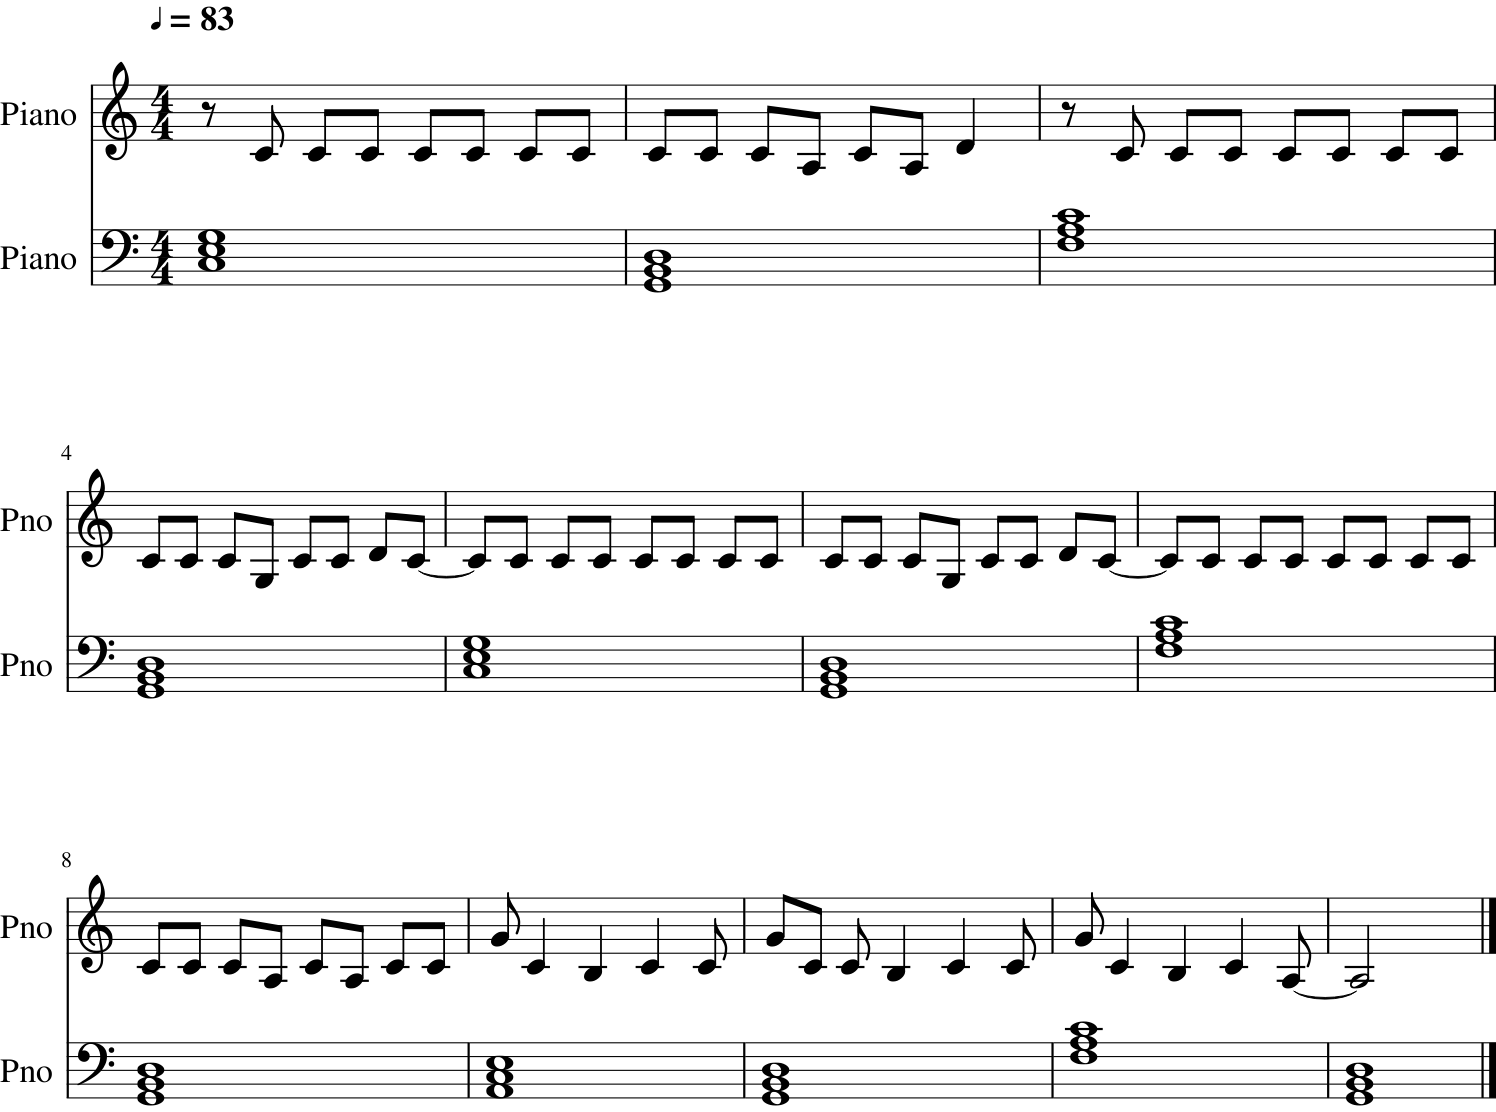

In [20]:
stream.show()

In [23]:
chordarr = stream2chordarr(stream, max_dur=max_dur, flat=False)
seq = chordarr2seq(chordarr)
npenc = seq2npenc(seq, num_comps=num_comps, category=1)

In [25]:
out_stream = npenc2stream(npenc)

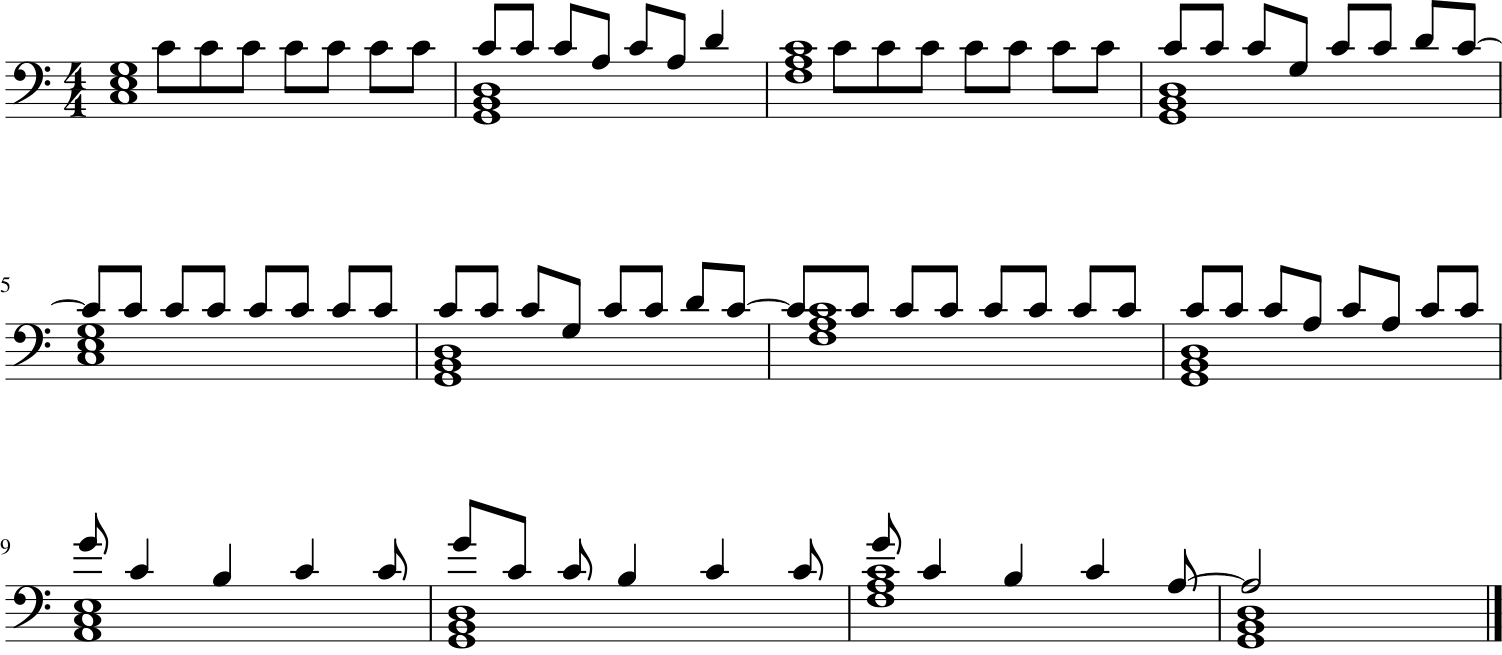

In [26]:
out_stream.show()

In [28]:
out_stream.show('midi')

## Transform

In [19]:
def transform_func(metadata):
    result = metadata.copy()
    
    # Part 1. Compress tracks/instruments
    if not isinstance(metadata.get('midi'), str): return None
    
    input_path = version_path/metadata['midi']
    extension = input_path.suffix.lower()
    if not input_path.exists(): 
        print('Input path does not exist:', input_path, metadata)
        return None
    
    # Get outfile and check if it exists
    out_file = Path(str(input_path).replace(f'/{source_dir}/', f'/{out_dir}/'))
    out_file = out_file.with_suffix('.npy')
    out_file.parent.mkdir(parents=True, exist_ok=True)
    if out_file.exists(): 
        result['numpy'] = str(out_file.relative_to(version_path))
        return result
    
    # DEBUG
    return None
    
    try: input_file = compress_midi_file(input_path, cutoff=cutoff) # remove non note tracks and standardize instruments
    except music21.midi.MidiException as e:
        print('Error parsing midi', input_path, e)
        return None
    if not input_file: return None
        
    # Part 2. Compress rests and long notes
    stream = file2stream(input_file) # 1.
    try:
        chordarr = stream2chordarr(stream, max_dur=max_dur, flat=False) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
#     chordarr = stream2chordarr(stream, max_dur=max_dur, flat=(extension != '.mid')) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
    except Exception as e:
        print('Could not encode to chordarr:', input_path, e)
#         print(traceback.format_exc())
        return None
    
    chord_trim = trim_chordarr_rests(chordarr)
    chord_short = shorten_chordarr_rests(chord_trim)
    delta_trim = chord_trim.shape[0] - chord_short.shape[0]
    if delta_trim > 300: 
        print(f'Removed {delta_trim} rests from {input_path}. Skipping song')
        return None
    chordarr = chord_short
    
    # Part 3. Chord array to numpy
    seq = chordarr2seq(chordarr)
    if len(seq) < 32:
        print('Sequence too short:', len(seq), input_path)
        return None
    
#     category = ENC_OFFSET + max_dur + sources.index(metadata['source']) + 1
    category = source2encidx(metadata['source'], max_dur=max_dur)
    npenc = seq2npenc(seq, num_comps=num_comps, category=category)
    if (npenc[1:,1] > max_dur+ENC_OFFSET).any(): 
        print('npenc exceeds max 128 duration:', input_path)
        return None
    
    if ((npenc[...,0] > ENC_OFFSET) & ((npenc[...,0] < 12+ENC_OFFSET) | (npenc[...,0] >= 127-12+ENC_OFFSET))).any(): 
        print('npenc out of note range 12 - 116:', input_path)
        return None
    
    
    np.save(out_file, npenc)
    
    result['numpy'] = str(out_file.relative_to(version_path))
    return result

In [24]:
import traceback
import sys

def try_transform_func(metadata):
    try:
        return transform_func(metadata)
    except Exception:
        print(traceback.format_exc())
        return None

In [21]:
# # sanity check
# import random
# for r in random.sample(mxl_records, 500):
#     transform_func(r)
        

NameError: name 'mxl_records' is not defined

In [14]:
### AS TOD: Fix 'info channel is not channel 0' error

In [25]:
processed = process_all(try_transform_func, all_records)

In [26]:
from src.data_sources import arr2csv

In [27]:
arr2csv(processed, out_csv); len(processed)

In [30]:
df = pd.read_csv(out_csv)

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,2,6,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
df.head()

,section,ht_mode,mxl,artist,midi,genres,midi_title,ht_offset,parts,numpy,song_url,ht_key,ht_time_signature,ht_bpm,title,source,md5
0,chorus,1.0,NaN,wayne-sharpe,midi_sources/hooktheory/pianoroll/w/wayne-shar...,NaN,yu-gi-oh3,0.0,"intro,chorus",midi_encode/hooktheory/pianoroll/w/wayne-sharp...,https://www.hooktheory.com/theorytab/view/wayn...,C,4.0,128.0,yu-gi-oh-theme-song,hooktheory,bf1f29e5ff84e3e93e37fb873bfb590e
1,pre-chorus,6.0,NaN,whiteflame,midi_sources/hooktheory/pianoroll/w/whiteflame...,"J-Pop,Pop",senbonzakura - pre-Pre-Chorus,-5.0,"verse,pre-chorus,chorus",midi_encode/hooktheory/pianoroll/w/whiteflame/...,https://www.hooktheory.com/theorytab/view/whit...,D,4.0,152.0,senbonzakura,hooktheory,9e7ce13a35f1314423a9a6d5a5287a4a
2,chorus,6.0,NaN,what-a-day,midi_sources/hooktheory/pianoroll/w/what-a-day...,Jazz,kiefer,-5.0,chorus,midi_encode/hooktheory/pianoroll/w/what-a-day/...,https://www.hooktheory.com/theorytab/view/what...,D,4.0,96.0,kiefer,hooktheory,197f96f5d181f6ce1e2c5ab04ac1ff87
3,intro,1.0,NaN,wayne-sharpe,midi_sources/hooktheory/pianoroll/w/wayne-shar...,NaN,yu-gi-oh,0.0,"intro,chorus",midi_encode/hooktheory/pianoroll/w/wayne-sharp...,https://www.hooktheory.com/theorytab/view/wayn...,C,3.0,85.0,yu-gi-oh-theme-song,hooktheory,055f80ad67f64edb14a85ca8fbfe8c29
4,verse,6.0,NaN,whiteflame,midi_sources/hooktheory/pianoroll/w/whiteflame...,"J-Pop,Pop",Senbonzakura,-5.0,"verse,pre-chorus,chorus",midi_encode/hooktheory/pianoroll/w/whiteflame/...,https://www.hooktheory.com/theorytab/view/whit...,D,4.0,152.0,senbonzakura,hooktheory,d5aaf79d0989222f1362f9f46c540a27
